# 葡萄酒分类比较 - 决策树 / 逻辑回归 / 神经网络 (PyTorch)
# 2252938沈诗凡

In [18]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os
from datetime import datetime

In [19]:
# ======== 可配置项 =========
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [20]:
# 数据准备：使用 sklearn 的 wine 数据（3 类）
data = load_wine()
X = data['data']
y = data['target']
feature_names = data['feature_names']
target_names = data['target_names']

X.shape
y.shape

(178,)

In [21]:
# 拆分：train / val / test (60% / 20% / 20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=RANDOM_SEED, stratify=y_train_full
)  # 0.25*0.8 = 0.2 -> 60/20/20

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("样本数：训练", X_train.shape[0], "验证", X_val.shape[0], "测试", X_test.shape[0])

样本数：训练 106 验证 36 测试 36


In [22]:
# 决策树 - GridSearchCV 找最优参数
dt_param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 4, 6, 10],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_cv = GridSearchCV(dt, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_cv.fit(X_train_scaled, y_train)
best_dt = dt_cv.best_estimator_
print("决策树 best params:", dt_cv.best_params_)
print("决策树 CV best score:", dt_cv.best_score_)

# 验证与测试表现
def eval_model_sklearn(model, X_tr, y_tr, X_v, y_v, X_t, y_t, name="Model"):
    res = {}
    for split_name, Xs, ys in [('train', X_tr, y_tr), ('val', X_v, y_v), ('test', X_t, y_t)]:
        preds = model.predict(Xs)
        acc = accuracy_score(ys, preds)
        prf = precision_recall_fscore_support(ys, preds, average='weighted', zero_division=0)
        res[split_name] = {'accuracy': acc, 'precision': prf[0], 'recall': prf[1], 'f1': prf[2]}
    print(name, "评估：")
    for k,v in res.items():
        print(k, v)
    return res

dt_results = eval_model_sklearn(best_dt, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, name="DecisionTree")

决策树 best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
决策树 CV best score: 0.8965367965367965
DecisionTree 评估：
train {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
val {'accuracy': 0.9166666666666666, 'precision': 0.9188034188034189, 'recall': 0.9166666666666666, 'f1': 0.9167901234567901}
test {'accuracy': 0.8888888888888888, 'precision': 0.8931623931623931, 'recall': 0.8888888888888888, 'f1': 0.8898245614035089}


In [23]:
# 逻辑回归 - GridSearchCV 找最优参数
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}
lr = LogisticRegression(max_iter=10000, multi_class='multinomial', random_state=RANDOM_SEED)
lr_cv = GridSearchCV(lr, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_cv.fit(X_train_scaled, y_train)
best_lr = lr_cv.best_estimator_
print("逻辑回归 best params:", lr_cv.best_params_)
print("逻辑回归 CV best score:", lr_cv.best_score_)

lr_results = eval_model_sklearn(best_lr, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, name="LogisticRegression")

逻辑回归 best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
逻辑回归 CV best score: 0.9904761904761905
LogisticRegression 评估：
train {'accuracy': 0.9905660377358491, 'precision': 0.9908913467794406, 'recall': 0.9905660377358491, 'f1': 0.9905932978951263}
val {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
test {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


D:\ProgramData\miniconda3\envs\deep-learning\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [24]:
# 神经网络 (PyTorch) - 多层感知机 MLP，含早停与保存
# 尝试若干超参数组合（hidden_sizes, lr, batch_size）

# 将 numpy 转为 torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64], dropout=0.2, num_classes=3):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def train_evaluate_nn(hidden_dims=[64], lr=1e-3, batch_size=32, num_epochs=100, patience=10, weight_decay=0):
    model = MLP(input_dim=X_train.shape[1], hidden_dims=hidden_dims, dropout=0.2, num_classes=len(np.unique(y)))
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds = TensorDataset(X_val_t, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    best_val_acc = 0.0
    best_state = None
    patience_cnt = 0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
        train_loss = total_loss / total
        train_acc = correct / total

        # 验证
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item() * xb.size(0)
                preds = out.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_total += xb.size(0)
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # 早停 & 保存 best
        if val_acc > best_val_acc + 1e-6:
            best_val_acc = val_acc
            best_state = model.state_dict()
            patience_cnt = 0
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                break

    # 载入 best
    if best_state is not None:
        model.load_state_dict(best_state)

    # 在 train/val/test 上评估
    def eval_torch_model(m, X_tensor, y_tensor):
        m.eval()
        with torch.no_grad():
            X_tensor = X_tensor.to(device)
            out = m(X_tensor)
            preds = out.argmax(dim=1).cpu().numpy()
        acc = accuracy_score(y_tensor.numpy(), preds)
        prf = precision_recall_fscore_support(y_tensor.numpy(), preds, average='weighted', zero_division=0)
        return {'accuracy': acc, 'precision': prf[0], 'recall': prf[1], 'f1': prf[2], 'preds': preds}

    train_metrics = eval_torch_model(model, X_train_t, y_train_t)
    val_metrics = eval_torch_model(model, X_val_t, y_val_t)
    test_metrics = eval_torch_model(model, X_test_t, y_test_t)

    return {
        'model': model,
        'history': history,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics
    }

In [25]:

# 定义要尝试的超参数组合
nn_param_grid = [
    {'hidden_dims': [64], 'lr': 1e-3, 'batch_size': 16},
    {'hidden_dims': [128], 'lr': 1e-3, 'batch_size': 16},
    {'hidden_dims': [64, 32], 'lr': 1e-3, 'batch_size': 32},
    {'hidden_dims': [128, 64], 'lr': 5e-4, 'batch_size': 32},
]

best_nn_result = None
best_val_acc = 0.0
best_config = None

for cfg in nn_param_grid:
    print("训练 NN 配置:", cfg)
    res = train_evaluate_nn(hidden_dims=cfg['hidden_dims'], lr=cfg['lr'], batch_size=cfg['batch_size'],
                            num_epochs=200, patience=20, weight_decay=1e-4)
    val_acc = res['val_metrics']['accuracy']
    print("验证准确率:", val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_nn_result = res
        best_config = cfg

print("最佳 NN 配置:", best_config, "验证 acc:", best_val_acc)
nn_results = {
    'train': best_nn_result['train_metrics'],
    'val': best_nn_result['val_metrics'],
    'test': best_nn_result['test_metrics']
}



训练 NN 配置: {'hidden_dims': [64], 'lr': 0.001, 'batch_size': 16}
验证准确率: 0.9722222222222222
训练 NN 配置: {'hidden_dims': [128], 'lr': 0.001, 'batch_size': 16}
验证准确率: 1.0
训练 NN 配置: {'hidden_dims': [64, 32], 'lr': 0.001, 'batch_size': 32}
验证准确率: 1.0
训练 NN 配置: {'hidden_dims': [128, 64], 'lr': 0.0005, 'batch_size': 32}
验证准确率: 1.0
最佳 NN 配置: {'hidden_dims': [128], 'lr': 0.001, 'batch_size': 16} 验证 acc: 1.0


In [26]:
# 汇总比较结果
rows = []
# 决策树
rows.append({
    'model': 'DecisionTree',
    'train_acc': dt_results['train']['accuracy'],
    'val_acc': dt_results['val']['accuracy'],
    'test_acc': dt_results['test']['accuracy'],
    'train_f1': dt_results['train']['f1'],
    'val_f1': dt_results['val']['f1'],
    'test_f1': dt_results['test']['f1'],
})
# 逻辑回归
rows.append({
    'model': 'LogisticRegression',
    'train_acc': lr_results['train']['accuracy'],
    'val_acc': lr_results['val']['accuracy'],
    'test_acc': lr_results['test']['accuracy'],
    'train_f1': lr_results['train']['f1'],
    'val_f1': lr_results['val']['f1'],
    'test_f1': lr_results['test']['f1'],
})
# NN
rows.append({
    'model': f'NeuralNetwork_{best_config}',
    'train_acc': nn_results['train']['accuracy'],
    'val_acc': nn_results['val']['accuracy'],
    'test_acc': nn_results['test']['accuracy'],
    'train_f1': nn_results['train']['f1'],
    'val_f1': nn_results['val']['f1'],
    'test_f1': nn_results['test']['f1'],
})

cmp_df = pd.DataFrame(rows)
print("\n模型比较表：")
display(cmp_df)


模型比较表：


,model,train_acc,val_acc,test_acc,train_f1,val_f1,test_f1
0,DecisionTree,1.000000,0.916667,0.888889,1.000000,0.91679,0.889825
1,LogisticRegression,0.990566,1.000000,1.000000,0.990593,1.00000,1.000000
2,"NeuralNetwork_{'hidden_dims': [128], 'lr': 0.0...",1.000000,1.000000,0.972222,1.000000,1.00000,0.971970



=== 决策树 在测试集上的分类报告 ===
              precision    recall  f1-score   support

     class_0       0.85      0.92      0.88        12
     class_1       0.86      0.86      0.86        14
     class_2       1.00      0.90      0.95        10

    accuracy                           0.89        36
   macro avg       0.90      0.89      0.89        36
weighted avg       0.89      0.89      0.89        36

混淆矩阵：
 [[11  1  0]
 [ 2 12  0]
 [ 0  1  9]]

=== 逻辑回归 在测试集上的分类报告 ===
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

混淆矩阵：
 [[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]

=== 神经网络 在测试集上的分类报告 ===
              precision    recall  f1-score   support

     class_0       1.

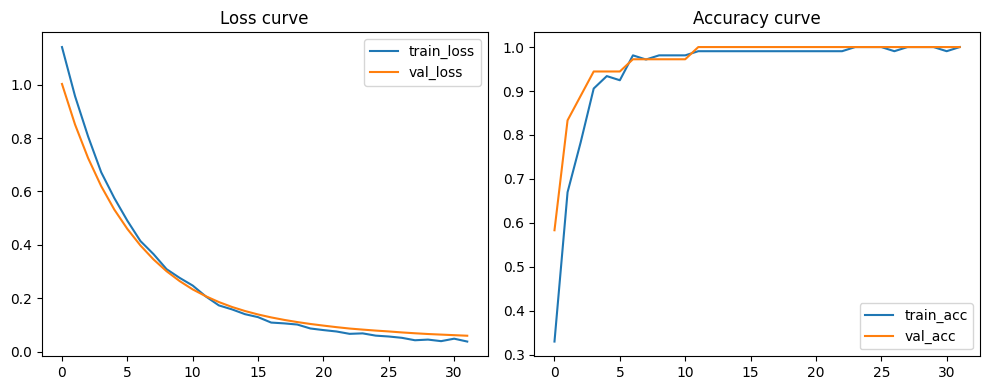

In [27]:
# 打印最佳模型的详细报告（混淆矩阵 / classification_report）
print("\n=== 决策树 在测试集上的分类报告 ===")
dt_test_preds = best_dt.predict(X_test_scaled)
print(classification_report(y_test, dt_test_preds, target_names=target_names))
print("混淆矩阵：\n", confusion_matrix(y_test, dt_test_preds))

print("\n=== 逻辑回归 在测试集上的分类报告 ===")
lr_test_preds = best_lr.predict(X_test_scaled)
print(classification_report(y_test, lr_test_preds, target_names=target_names))
print("混淆矩阵：\n", confusion_matrix(y_test, lr_test_preds))

print("\n=== 神经网络 在测试集上的分类报告 ===")
nn_test_preds = best_nn_result['test_metrics']['preds']  # numpy preds
print(classification_report(y_test, nn_test_preds, target_names=target_names))
print("混淆矩阵：\n", confusion_matrix(y_test, nn_test_preds))

# 7. 可视化 NN 最佳训练曲线
hist = best_nn_result['history']
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist['train_loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.title('Loss curve')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['train_acc'], label='train_acc')
plt.plot(hist['val_acc'], label='val_acc')
plt.title('Accuracy curve')
plt.legend()
plt.tight_layout()
plt.show()



In [28]:
# 保存最佳 NN 模型（.pth）
save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
nn_model_path = os.path.join(save_dir, f"best_model_ANN2.pth")
torch.save(best_nn_result['model'].state_dict(), nn_model_path)
print("最佳 NN 模型已保存到：", nn_model_path)

最佳 NN 模型已保存到： ./models\best_model_ANN2.pth
